<a href="https://colab.research.google.com/github/siddhantkd/Hand-Gesture_DeepLearning/blob/main/AEC_EE_Model_SKD_LinkNET%5Bmobilenetv2%5D_ASPP%2Bsam_2%5B500epochs%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# **AEC _ EE - NET** 

1. ResNet18_LINKNET with ASPP

LINKNET _ ASPP [ 512 deconv filters ]

BEST 30 epochs

> F - 0.9801724121093752

> IoU socre is:  0.8403416923529685

ASPP [ 256 deconv filters ]

> F 0.9805174218749996

> IOU : IoU socre is:  0.8417632228496972 / 0.8403  ( no y test change )

> Epochs 60 ( CONVERGED ) 


2. mobilenetv2_LINKNET with ASPP_64

ASPP [ 64 deconv filters ]

> F - 0.9800259472656246

> IoU socre is: 0.8349840733116369

> Epochs 30 ( CONVERGED ) 

3. mobilenetv2_LINKNET with sam + ASPPP



#IMPORT AND DRIVE LOAD

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [ ]:
!nvidia-smi

Sat Jan 15 11:06:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


#Data Loading

In [ ]:
!unzip '/content/drive/MyDrive/OUHANDS/OUHANDS_Siddhant.zip'

In [ ]:
IMG_WIDTH = 320
IMG_HEIGHT = 320
IMG_CHANNELS = 3

In [ ]:
path = "/content/OUHANDS_Siddhant/training/colour"
maskpath = "/content/OUHANDS_Siddhant/training/segmentation"

X_train = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating input data')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_train[n]=img
    n+=1

m=0
for name in tqdm(os.listdir(maskpath)):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath,0)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg=np.expand_dims(mpg,axis=-1)
    Y_train[m]=mpg/255
    m+=1

creating input data


100%|██████████| 2000/2000 [00:02<00:00, 696.91it/s]


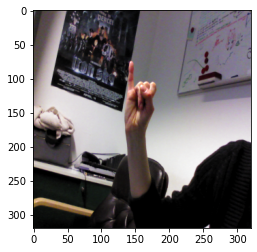

In [ ]:
plt.imshow(array_to_img(X_train[0]))

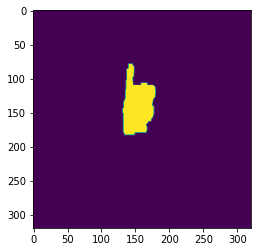

In [ ]:
plt.imshow(array_to_img(Y_train[0]))

In [ ]:
print(X_train.shape, Y_train.shape)

(2000, 320, 320, 3) (2000, 320, 320, 1)


# AEC_EE Model

In [ ]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, Conv2DTranspose, Add, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *

In [ ]:
def ASPP(inputs):

    conv_filters = 64
    """ Image Pooling """
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(conv_filters, 1, padding="same", use_bias=False)(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    """ 1x1 conv """
    y2 = Conv2D(conv_filters, 1, padding="same", use_bias=False)(inputs)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    """ 3x3 conv rate=6 """
    y3 = Conv2D(conv_filters, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    """ 3x3 conv rate=12 """
    y4 = Conv2D(conv_filters, 3, padding="same", use_bias=False, dilation_rate=12)(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    """ 3x3 conv rate=18 """
    y5 = Conv2D(conv_filters, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(conv_filters, 1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

In [ ]:
def sa_block(inputs):
    """
    Spatial Attention Module utilizing the inter-spatial relationship of features.
    """
    kernel_size = 3

    # avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(inputs)
    # max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(inputs)
    avg_pool = K.mean(inputs, axis=-1, keepdims=True)
    max_pool = K.max(inputs, axis=-1, keepdims=True)

    x = Concatenate()([avg_pool, max_pool])

    x = Conv2D(1, kernel_size, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(x)

    outputs = Multiply()([inputs, x])
    return outputs

In [ ]:
"""Skip connections as per SM Models LINKnet with backbone mobilenetv2"""

# LATEST MODEL - LINKNET only

def build_LinkNet_mobilenetv2():    
  model = tf.keras.applications.MobileNetV2(input_shape=(320, 320,3), include_top=False, weights="imagenet")

  """ Skip Connections """

  s1 = model.get_layer("block_1_expand_relu").output         ## (160, 160)
  s1 = sa_block(s1)
  s2 = model.get_layer("block_3_expand_relu").output         ## ( 80, 80)
  s2 = sa_block(s2)
  s3 = model.get_layer("block_6_expand_relu").output         ## (40, 40)
  s3 = sa_block(s3)
  s4 = model.get_layer("block_13_expand_relu").output         ## (20, 20)
  s4 = sa_block(s4)

  #print(s1.shape, s2.shape, s3.shape, s4.shape)

  """ Bridge """

  b1 = model.get_layer("out_relu").output
  b1 = ASPP(b1)
  #print(b1.shape)

  """ Decoder """
  x = Conv2D(320, (1,1), kernel_initializer='he_normal', padding = 'same')(b1)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(320, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(576, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s4]) # ADD 1

  x = Conv2D(144, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(144, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(192, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s3]) # ADD 2

  x = Conv2D(48, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(48, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(144, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s2]) # ADD 3

  x = Conv2D(36, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(36, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(96, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s1]) # ADD 4

  x = Conv2D(24, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(24, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(16, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  outputs = Conv2D(1, 1, kernel_initializer='he_normal',padding="same")(x)
  outputs = Activation('sigmoid')(outputs)

  model = keras.models.Model(inputs=[model.input], outputs=[outputs])  

  #print(model.summary())

  return model

In [ ]:
model = build_LinkNet_mobilenetv2()
print(model.summary())

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 160, 160, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 160, 160, 32  128         ['Conv1[0][0]']                  
                               

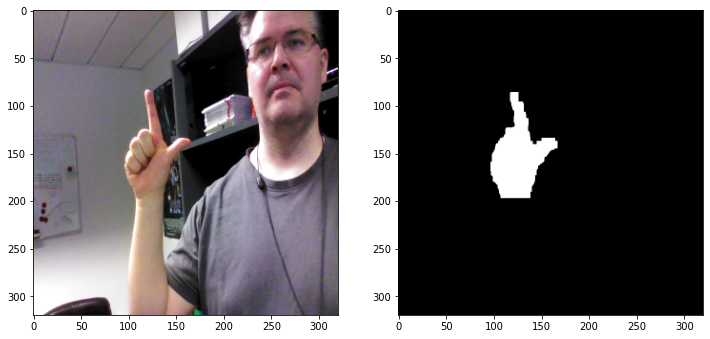

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number])
plt.subplot(122)
plt.imshow(array_to_img(Y_train[image_number]), cmap='gray')
plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
model.compile(loss=dice_loss, optimizer=Adam(1e-4), metrics=[dice_coef, iou, "accuracy"])

# MODEL TRAINING

## 500 epochs

BATCH SIZE = 16 

In [ ]:
"""
#Model Checkpoint
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_mobilenetv2/SAM_ASPP/cp.ckpt"
model_checkpoint_segmentUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_segmentUNET,
                                                 save_weights_only=True,
                                                  monitor='val_iou', mode="max",save_best_only=True,
                                                 verbose=1)                                                  
"""

In [ ]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=16, epochs=500)

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 500
plt.plot(np.arange(0,N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), history.history["iou"], label = "train_iou_score")
plt.plot(np.arange(0,N), history.history["val_iou"], label = "val_iou_score")
plt.legend(loc="center right")
plt.title("Training Loss and IOU plot")
plt.xlabel("Epochs")
plt.savefig('UNET_Traininerrorplot_SEGMENTATION_RGB.png')

In [ ]:
plt.plot(np.arange(0,N), history.history["accuracy"])
plt.title("Training accuracy plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [ ]:
plt.plot(np.arange(0,N), history.history["val_accuracy"], label = "val_accuracy")
plt.title("Validation accuracy plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [ ]:
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [ ]:
plt.plot(np.arange(0,N), history.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epochs")
plt.ylabel("Loss")

##30 Epochs

In [ ]:
checkpoint_path_segmentUNET = ""
model.load_weights(checkpoint_path_segmentUNET)

In [ ]:
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_mobilenetv2/SAM/30/cp.ckpt"
model_checkpoint_segmentUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_segmentUNET,
                                                 save_weights_only=True,
                                                  monitor='val_accuracy',save_best_only=True,
                                                 verbose=1)

In [ ]:
h2 =  model.fit(X_train,Y_train,validation_data = (X_test, Y_test),batch_size=16,epochs=20, callbacks=[model_checkpoint_segmentUNET])

Epoch 1/10
225/225 [==============================] - ETA: 0s - loss: 0.0447 - dice_coef: 0.9553 - iou: 0.9145 - accuracy: 0.9914
Epoch 00001: val_accuracy improved from -inf to 0.98609, saving model to /content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_mobilenetv2/SAM/30/cp.ckpt
225/225 [==============================] - 53s 237ms/step - loss: 0.0447 - dice_coef: 0.9553 - iou: 0.9145 - accuracy: 0.9914 - val_loss: 0.0646 - val_dice_coef: 0.9354 - val_iou: 0.8787 - val_accuracy: 0.9861
Epoch 2/10
225/225 [==============================] - ETA: 0s - loss: 0.0414 - dice_coef: 0.9586 - iou: 0.9205 - accuracy: 0.9917
Epoch 00002: val_accuracy improved from 0.98609 to 0.98626, saving model to /content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_mobilenetv2/SAM/30/cp.ckpt
225/225 [==============================] - 53s 236ms/step - loss: 0.0414 - dice_coef: 0.9586 - iou: 0.9205 - accuracy: 0.9917 - val_loss: 0.0620 - val_dice_coef: 0.9380 - val_iou: 0.8833 - val_accuracy: 0.9863
Epoch 3/10
225/225 [=======

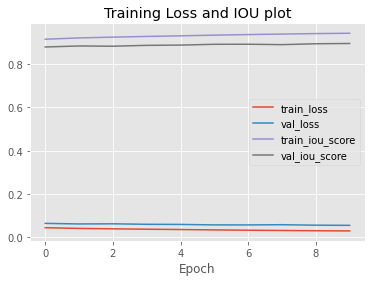

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 10
plt.plot(np.arange(0,N), h2.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), h2.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), h2.history["iou"], label = "train_iou_score")
plt.plot(np.arange(0,N), h2.history["val_iou"], label = "val_iou_score")
plt.legend(loc="center right")
plt.title("Training Loss and IOU plot")
plt.xlabel("Epoch")
plt.savefig('UNET_Traininerrorplot_SEGMENTATION_RGB.png')

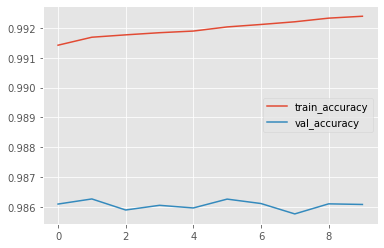

In [ ]:
plt.plot(np.arange(0,N), h2.history["accuracy"], label = "train_accuracy")
plt.plot(np.arange(0,N), h2.history["val_accuracy"], label = "val_accuracy")
plt.legend(loc="center right")

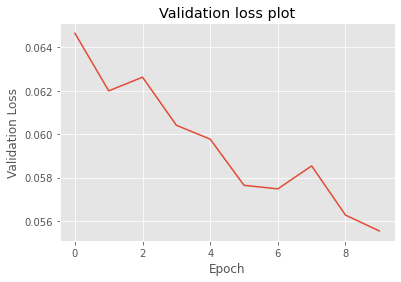

In [ ]:
plt.plot(np.arange(0,N), h2.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.savefig('UNET_ValLossPlot_SEGMENTATION_V1.2.png')

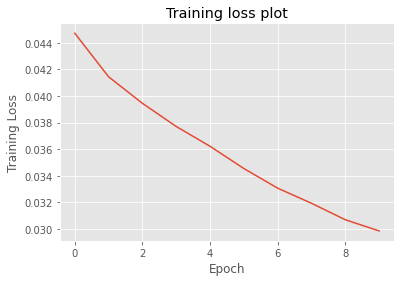

In [ ]:
plt.plot(np.arange(0,N), h2.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('UNET_TrainLossPlot_SEGMENTATION_V1.2.png')

## 40

In [ ]:
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_mobilenetv2/SAM_ASPP/40/cp.ckpt"
model_checkpoint_segmentUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_segmentUNET,
                                                 save_weights_only=True,
                                                  monitor='val_iou', mode="max",save_best_only=True,
                                                 verbose=1)

In [ ]:
h3 =  model.fit(X_train,Y_train,validation_data = (X_test, Y_test),batch_size=16,epochs=20, callbacks=[model_checkpoint_segmentUNET])

Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 0.1251 - dice_coef: 0.8749 - iou: 0.7780 - accuracy: 0.9908
Epoch 00001: val_iou improved from -inf to 0.70447, saving model to /content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_mobilenetv2/SAM_ASPP/40/cp.ckpt
125/125 [==============================] - 65s 523ms/step - loss: 0.1251 - dice_coef: 0.8749 - iou: 0.7780 - accuracy: 0.9908 - val_loss: 0.1761 - val_dice_coef: 0.8243 - val_iou: 0.7045 - val_accuracy: 0.9775
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.1158 - dice_coef: 0.8842 - iou: 0.7929 - accuracy: 0.9910
Epoch 00002: val_iou improved from 0.70447 to 0.71840, saving model to /content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_mobilenetv2/SAM_ASPP/40/cp.ckpt
125/125 [==============================] - 66s 529ms/step - loss: 0.1158 - dice_coef: 0.8842 - iou: 0.7929 - accuracy: 0.9910 - val_loss: 0.1664 - val_dice_coef: 0.8340 - val_iou: 0.7184 - val_accuracy: 0.9782
Epoch 3/20
125/125 [=======

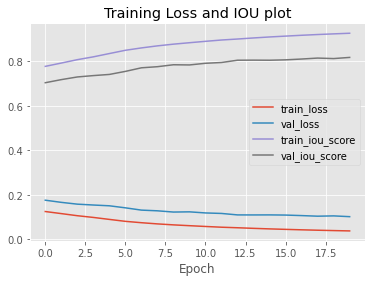

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 20
plt.plot(np.arange(0,N), h3.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), h3.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), h3.history["iou"], label = "train_iou_score")
plt.plot(np.arange(0,N), h3.history["val_iou"], label = "val_iou_score")
plt.legend(loc="center right")
plt.title("Training Loss and IOU plot")
plt.xlabel("Epoch")
plt.savefig('UNET_Traininerrorplot_SEGMENTATION_RGB.png')

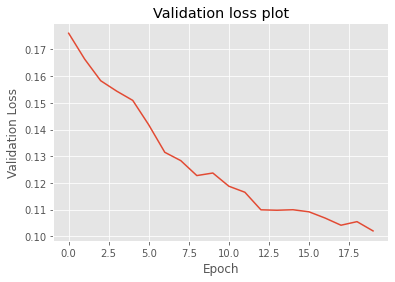

In [ ]:
plt.plot(np.arange(0,N), h3.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.savefig('UNET_ValLossPlot_SEGMENTATION_V1.2.png')

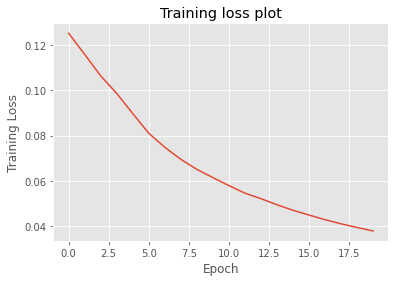

In [ ]:
plt.plot(np.arange(0,N), h3.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('UNET_TrainLossPlot_SEGMENTATION_V1.2.png')

## 50

In [ ]:
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_mobilenetv2/SAM_ASPP/50/cp.ckpt"
model_checkpoint_segmentUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_segmentUNET,
                                                 save_weights_only=True,
                                                  monitor='val_iou', mode="max",save_best_only=True,
                                                 verbose=1)

In [ ]:
h4 =  model.fit(X_train,Y_train,validation_data = (X_test, Y_test),batch_size=16,epochs=10, callbacks=[model_checkpoint_segmentUNET])

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 0.0363 - dice_coef: 0.9637 - iou: 0.9299 - accuracy: 0.9930
Epoch 00001: val_iou improved from -inf to 0.82023, saving model to /content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_mobilenetv2/SAM_ASPP/50/cp.ckpt
125/125 [==============================] - 66s 526ms/step - loss: 0.0363 - dice_coef: 0.9637 - iou: 0.9299 - accuracy: 0.9930 - val_loss: 0.1012 - val_dice_coef: 0.8991 - val_iou: 0.8202 - val_accuracy: 0.9786
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 0.0351 - dice_coef: 0.9649 - iou: 0.9321 - accuracy: 0.9930
Epoch 00002: val_iou did not improve from 0.82023
125/125 [==============================] - 68s 543ms/step - loss: 0.0351 - dice_coef: 0.9649 - iou: 0.9321 - accuracy: 0.9930 - val_loss: 0.1030 - val_dice_coef: 0.8973 - val_iou: 0.8177 - val_accuracy: 0.9781
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.0342 - dice_coef: 0.9658 - iou: 0.9339 - accuracy: 0.

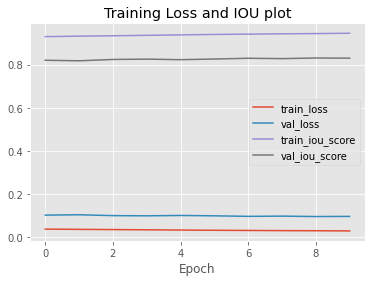

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 10
plt.plot(np.arange(0,N), h4.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), h4.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), h4.history["iou"], label = "train_iou_score")
plt.plot(np.arange(0,N), h4.history["val_iou"], label = "val_iou_score")
plt.legend(loc="center right")
plt.title("Training Loss and IOU plot")
plt.xlabel("Epoch")
plt.savefig('UNET_Traininerrorplot_SEGMENTATION_RGB.png')

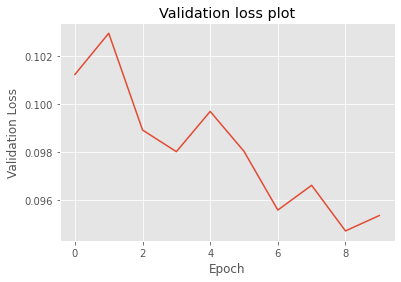

In [ ]:
plt.plot(np.arange(0,N), h4.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.savefig('UNET_ValLossPlot_SEGMENTATION_V1.2.png')

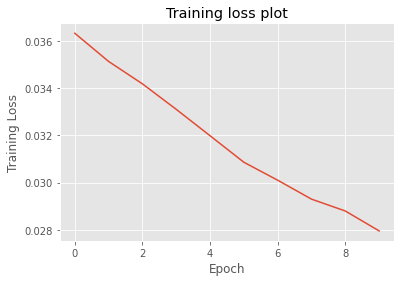

In [ ]:
plt.plot(np.arange(0,N), h4.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('UNET_TrainLossPlot_SEGMENTATION_V1.2.png')

## 60

In [ ]:
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP_256/60/cp.ckpt"
model_checkpoint_segmentUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_segmentUNET,
                                                 save_weights_only=True,
                                                  monitor='val_loss',save_best_only=True,
                                                 verbose=1)

In [ ]:
h5 =  model.fit(X_train,Y_train,validation_split = 0.1,batch_size=8,epochs=10,callbacks=[model_checkpoint_segmentUNET])

Epoch 1/10
225/225 [==============================] - ETA: 0s - loss: 0.0209 - dice_coef: 0.9791 - iou: 0.9590
Epoch 00001: val_loss improved from inf to 0.05104, saving model to /content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP_256/60/cp.ckpt
225/225 [==============================] - 98s 436ms/step - loss: 0.0209 - dice_coef: 0.9791 - iou: 0.9590 - val_loss: 0.0510 - val_dice_coef: 0.9490 - val_iou: 0.9030
Epoch 2/10
225/225 [==============================] - ETA: 0s - loss: 0.0207 - dice_coef: 0.9793 - iou: 0.9594
Epoch 00002: val_loss did not improve from 0.05104
225/225 [==============================] - 97s 432ms/step - loss: 0.0207 - dice_coef: 0.9793 - iou: 0.9594 - val_loss: 0.0520 - val_dice_coef: 0.9480 - val_iou: 0.9013
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 0.0205 - dice_coef: 0.9795 - iou: 0.9599
Epoch 00003: val_loss did not improve from 0.05104
225/225 [==============================] - 97s 432ms/step - loss: 0.0205 - dice_coef: 0

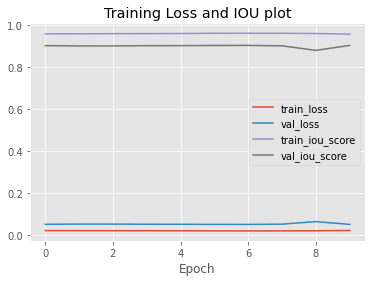

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 10
plt.plot(np.arange(0,N), h5.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), h5.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), h5.history["iou"], label = "train_iou_score")
plt.plot(np.arange(0,N), h5.history["val_iou"], label = "val_iou_score")
plt.legend(loc="center right")
plt.title("Training Loss and IOU plot")
plt.xlabel("Epoch")
plt.savefig('UNET_Traininerrorplot_SEGMENTATION_RGB.png')

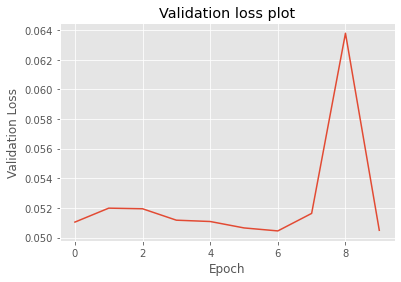

In [ ]:
plt.plot(np.arange(0,N), h5.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.savefig('UNET_ValLossPlot_SEGMENTATION_V1.2.png')

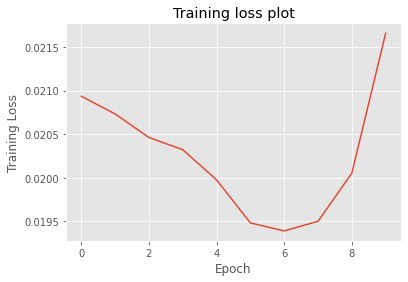

In [ ]:
plt.plot(np.arange(0,N), h5.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('UNET_TrainLossPlot_SEGMENTATION_V1.2.png')

# **EVALUATION**

In [ ]:
path = "/content/OUHANDS_Siddhant/testing/colour"
maskpath = "/content/OUHANDS_Siddhant/testing/segmentation"
p1 = os.listdir(path)
p1.sort()

m1 = os.listdir(maskpath)
m1.sort()

X_test = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_test = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating test data')
n=0
for name in tqdm(p1):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_test[n]=img
    n+=1

m=0
for name in tqdm(m1):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath,0)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg=np.expand_dims(mpg,axis=-1)
    Y_test[m]=mpg/255
    m+=1

creating test data


100%|██████████| 1000/1000 [00:01<00:00, 686.07it/s]


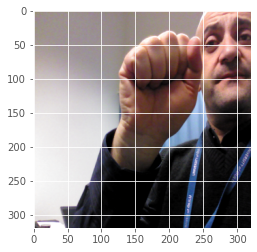

In [ ]:
plt.imshow(X_test[0])

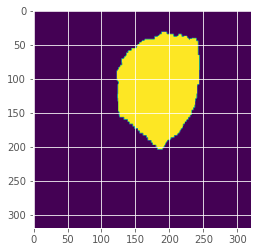

In [ ]:
plt.imshow(array_to_img(Y_test[0]))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import f1_score

In [ ]:
def fscore(tp,Images,Masks):
    total=0
    i=0
    fs=0
    for i in range(len(Images)):
        total += 1
        
        tp[i][tp[i]>0.5]=1
        tp[i][tp[i]<0.5]=0

        pred = img_to_array(tp[i]).astype(int)
        label = img_to_array(np.squeeze(Masks[i], axis=2)).astype(int)
        flat_pred = np.ravel(pred)
        flat_label = np.ravel(label)

        fs += f1_score(flat_label,flat_pred, average='micro')

    fs=fs/total

    return fs  

##20 epochs

In [ ]:
model.save("")

In [ ]:
 #    ######evaluate#####
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_mobilenetv2/SAM/cp.ckpt"
model.load_weights(checkpoint_path_segmentUNET)

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9787626953124975


In [ ]:
# loaded weighgts
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9793427148437502


AEC_EE_RESNET 18 encoder LINKNET

20 epochs 

IoU socre is: 0.8299967067687382

F - 0.9783507031249992

AEC_EE_mobilenetv2 encoder LINKNET

20 epochs 

IoU socre is: 0.8288960978777565

F - 0.9789355468750002

AEC_EE_mobilenetv2 encoder LINKNET ASPP 64

20 epochs 

IoU socre is: 0.8345382644454087

F - 0.9792402636718742


In [ ]:
## Jaccard Index ( IoU )

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8402654373827887


In [ ]:
## Jaccard Index ( IoU ) LOAD weights

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8292559845418486


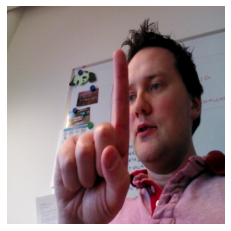

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(X_test[270]))
#plt.title('TEST IMAGE')

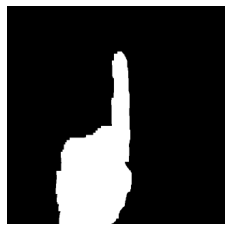

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(Y_test[270]), cmap = 'gray')
#plt.title('TEST SEGMENTATION MASK GROUND TRUTH', fontsize=8)

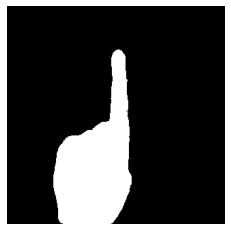

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(y_pred[270]), cmap = 'gray')
#plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

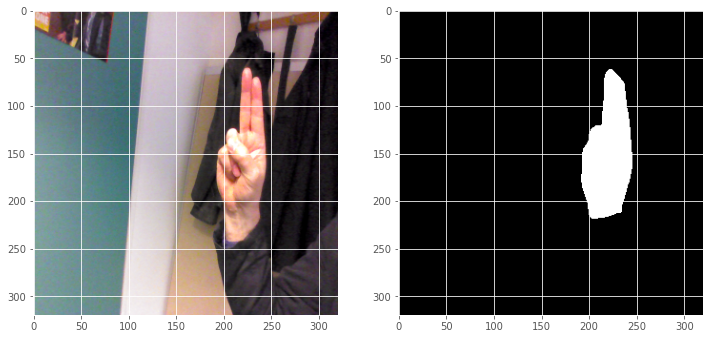

In [ ]:
#Prediction test
import random
import numpy as np
image_number = random.randint(0, len(X_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.subplot(122)
plt.imshow(array_to_img(y_pred[image_number]), cmap='gray')
plt.show()

In [ ]:
x_test_single = np.expand_dims(X_test[200], axis = 0)

In [ ]:
import time
start_time = time.time()
y_single = model.predict(x_test_single)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.15967488288879395 seconds ---


##30Epochs

In [ ]:
 #    ######evaluate#####
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_mobilenetv2/SAM/30/cp.ckpt"
model.load_weights(checkpoint_path_segmentUNET)

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9790668359374994


LINKNET mobilenet v2 _ ASPP 64

F - 0.9800259472656246

IoU socre is: 0.8349840733116369


In [ ]:
## Jaccard Index ( IoU )

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.83078125967913


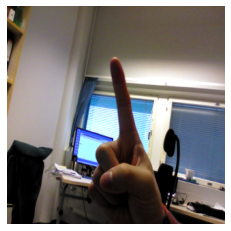

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(X_test[256]))
#plt.title('TEST IMAGE')

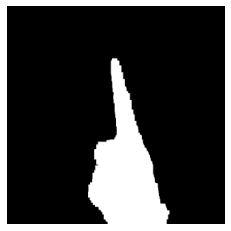

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(Y_test[256]), cmap = 'gray')
#plt.title('TEST SEGMENTATION MASK GROUND TRUTH', fontsize=8)

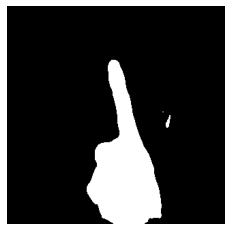

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(y_pred[256]), cmap = 'gray')
#plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

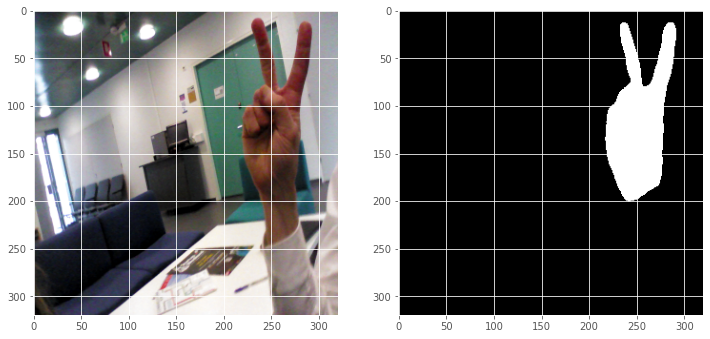

In [ ]:
#Prediction test
import random
import numpy as np
image_number = random.randint(0, len(X_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.subplot(122)
plt.imshow(array_to_img(y_pred[image_number]), cmap='gray')
plt.show()

In [ ]:
import time

In [ ]:

x_test_single = np.expand_dims(X_test[8], axis = 0)

start_time = time.time()
y_single = model.predict(x_test_single)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.147740125656128 seconds ---


## 40 epochs

In [ ]:
 #    ######evaluate#####
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_mobilenetv2/ASPP_64/40/cp.ckpt"
model.load_weights(checkpoint_path_segmentUNET)

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9806581640625012


In [ ]:
## Jaccard Index ( IoU )

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8416921581014744


mobilenet aspp 256

IoU socre is:  0.8409785793896284

F - 0.9805310644531233

mobilenet aspp 64

IoU socre is:  0.8289604497755984

F - 0.9792106347656248

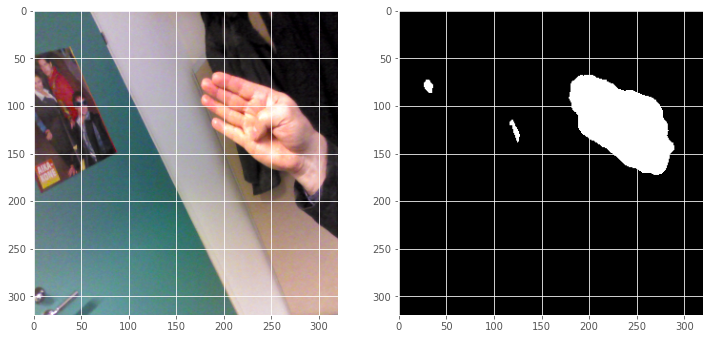

In [ ]:
#Prediction test
import random
import numpy as np
image_number = random.randint(0, len(X_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.subplot(122)
plt.imshow(array_to_img(y_pred[image_number]), cmap='gray')
plt.show()

## 50

In [ ]:
 #    ######evaluate#####
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_mobilenetv2/SAM_ASPP/50/cp.ckpt"
model.load_weights(checkpoint_path_segmentUNET)

NotFoundError: ignored

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9806778710937497


In [ ]:
## Jaccard Index ( IoU )

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8428276484484124


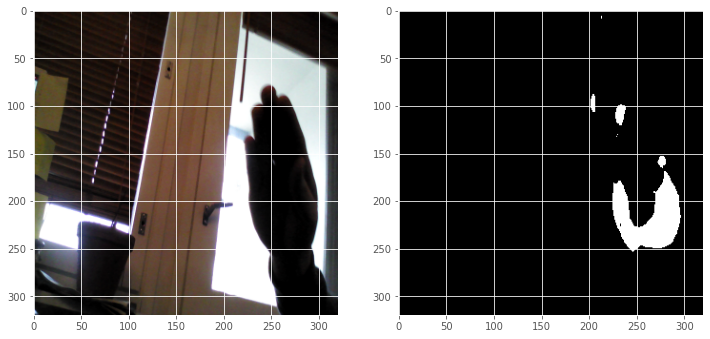

In [ ]:
#Prediction test
import random
import numpy as np
image_number = random.randint(0, len(X_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.subplot(122)
plt.imshow(array_to_img(y_pred[image_number]), cmap='gray')
plt.show()

## 60 

In [ ]:
 #    ######evaluate#####
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP_256/60/cp.ckpt"
model.load_weights(checkpoint_path_segmentUNET)

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9805174218749996


In [ ]:
y_pred_thresholded = y_pred > 0.5
Y_test = Y_test > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8417632228496972


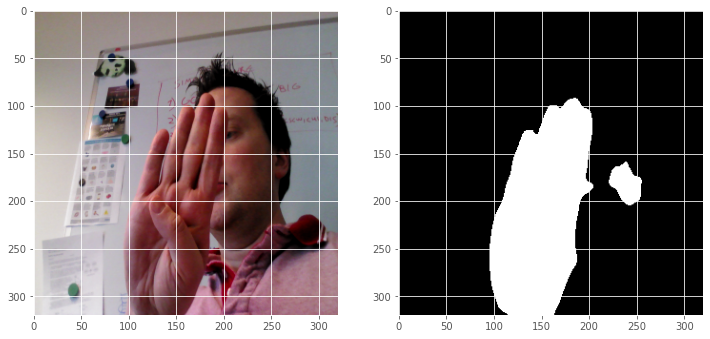

In [ ]:
#Prediction test
import random
import numpy as np
image_number = random.randint(0, len(X_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.subplot(122)
plt.imshow(array_to_img(y_pred[image_number]), cmap='gray')
plt.show()

#SAVE THE MODEL

In [ ]:
model.save("")